<a href="https://colab.research.google.com/github/ashu-vpu/DA231o_Course_Project_DataWatch/blob/main/Code/DE_scale_forecasting_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive to work from Google drive and Colab

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install Spark and instantiate the environment variable into the Colab host

In [38]:
#######################################
###!@0 START INIT ENVIRONMENT
!ls /content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"
###!@0 END INIT ENVIRONMENT

/content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz


Create symbolic links to the area where the datasets are present to work with

In [39]:
!mkdir -p /content/data
!rm -rf /content/data/*.csv
!ln -s /content/drive/MyDrive/DE_Scale_Project/Datasets/All_cities/*.csv /content/data/

Spark initiatlisation

In [40]:
#######################################
###!@1 START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

Read the dataset, i.e. ALL cities Pollutant data csv file

In [41]:
def read_csv(path_to_file):
  return spark.read.option("delimiter", ",").csv(path_to_file, header=True, inferSchema=True)

df_All_cities_2019_2022 = read_csv('/content/data/df_All_cities_2019_2022_processed.csv')
df_All_cities_2023 = read_csv('/content/data/df_All_cities_2023.csv')

Import Spark related functions and methods

In [42]:
# prompt: import all spark related libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

from pyspark.sql.functions import lag, col
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [44]:
# Try Forecasting
!pip install torch

In [46]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
from torch.utils.data import Dataset
import torch


# Assign train and test df and create lag columns in train df

#df_All_cities_2019_2022.show(5)
#df_All_cities_2023.show(5)

train_df = df_All_cities_2019_2022
test_df = df_All_cities_2023

# Create lag features for past 24 hours
window = Window.partitionBy("City").orderBy("Timestamp")
for lag_val in range(1, 25):
    train_df = train_df.withColumn(f"lag_{lag_val}", lag("AQI", lag_val).over(window))

# Drop rows with null values
train_df = train_df.dropna()
#train_df.show(5)

# Define features and label
feature_cols = [f"lag_{i}" for i in range(1, 25)] + ['PM2p5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone']
label_col = "AQI"

# Convert PySpark DataFrame to PyTorch Dataset

class SparkTorchDataset(Dataset):
    def __init__(self, spark_df, feature_cols, label_col):
        self.data = spark_df.rdd.map(
            lambda row: ([getattr(row, col) for col in feature_cols], getattr(row, label_col))
        ).collect()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features, label = self.data[idx]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# Create Dataset
train_dataset = SparkTorchDataset(train_df, feature_cols, label_col)

# Check the pytorch dataset
#features, label = train_dataset[0]
#print("Features:", features)
#print("Label:", label)
#print(f"Number of samples in train_dataset: {len(train_dataset)}")

In [47]:
# Define LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model Parameters
input_size = len(feature_cols)
hidden_size = 64
num_layers = 2
output_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [48]:
# Train the Model

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training Loop
epochs = 30
model.train()
for epoch in range(epochs):
    total_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")


Epoch 1/30, Loss: 10747.444955352736
Epoch 2/30, Loss: 4841.996138817665
Epoch 3/30, Loss: 1596.6361451207745
Epoch 4/30, Loss: 780.8200925516668
Epoch 5/30, Loss: 751.475135113805
Epoch 6/30, Loss: 593.152288068678
Epoch 7/30, Loss: 438.45659169081074
Epoch 8/30, Loss: 361.7536648260662
Epoch 9/30, Loss: 403.7076757554571
Epoch 10/30, Loss: 242.0399093043371
Epoch 11/30, Loss: 334.9965070016388
Epoch 12/30, Loss: 279.199690629257
Epoch 13/30, Loss: 257.57848905289154
Epoch 14/30, Loss: 237.05840473717421
Epoch 15/30, Loss: 332.8901884133217
Epoch 16/30, Loss: 188.3777118580413
Epoch 17/30, Loss: 328.8218533405949
Epoch 18/30, Loss: 245.15449364226765
Epoch 19/30, Loss: 220.49787352081347
Epoch 20/30, Loss: 197.71367012976094
Epoch 21/30, Loss: 187.67225703409687
Epoch 22/30, Loss: 303.4492154559818
Epoch 23/30, Loss: 288.0345953671665
Epoch 24/30, Loss: 326.45549537333267
Epoch 25/30, Loss: 236.2582533081561
Epoch 26/30, Loss: 193.94191017422065
Epoch 27/30, Loss: 175.1921916452441
Ep

In [49]:
# FOrecast AQI for year 2023

# Prepare input sequence for forecasting
window = Window.partitionBy("City").orderBy("Timestamp")
for lag_val in range(1, 25):
    test_df = test_df.withColumn(f"lag_{lag_val}", lag("AQI", lag_val).over(window))

test_df = test_df.dropna() # Drop rows with null values after creating lag features
test_dataset = SparkTorchDataset(test_df, feature_cols, label_col)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Forecast
model.eval()
forecasted_values = []
with torch.no_grad():
    for features, _ in test_loader:
        features = features.to(device)
        prediction = model(features).item()
        forecasted_values.append(prediction)


Mean Absolute Error (MAE): 11.421491548186712
Root Mean Square Error (RMSE): 14.621821812754053


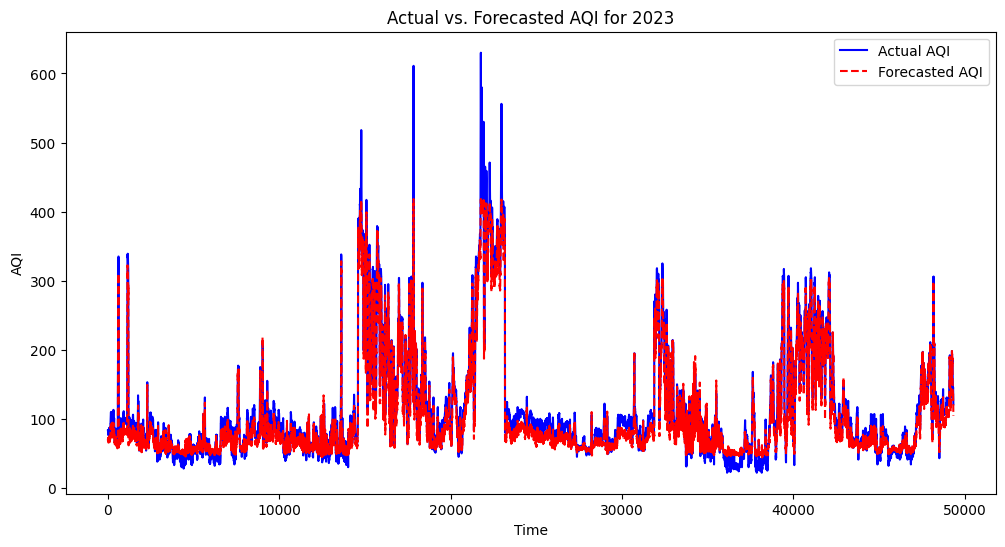

In [50]:
# Evaluate forecast accuracy and plot the forecasted and actual values

import numpy as np
import matplotlib.pyplot as plt

# Actual AQI values from 2023
actual_values = [row[1].item() for row in test_dataset]

# Calculate MAE and RMSE
mae = np.mean(np.abs(np.array(forecasted_values) - np.array(actual_values)))
rmse = np.sqrt(np.mean((np.array(forecasted_values) - np.array(actual_values))**2))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")



plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual AQI", color="blue")
plt.plot(forecasted_values, label="Forecasted AQI", color="red", linestyle="dashed")
plt.legend()
plt.title("Actual vs. Forecasted AQI for 2023")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.show()
